In [6]:
# import
import numpy as np
import tensor.tensor_product_wrapper as tp
from utils.plotting_utils import montage_array, slice_subplots
import matplotlib.pyplot as plt
import similarity_metrics as sm
from sklearn.model_selection import train_test_split
import scipy.io
import utils.starplus_utils as starp
from numpy.linalg import norm

In [7]:
# ==================================================================================================================== #
# for reproducibility
np.random.seed(20)

In [8]:
# load data
# we need the variables
#   training_data, training_labels, test_data, test_labels, num_classes
num_classes = 2
star_plus_data = scipy.io.loadmat('data-starplus-04847-v7.mat')
tensor_PS, labels = starp.get_labels(star_plus_data)
tensor_PS  = tensor_PS / norm(tensor_PS)

In [9]:
tensor_PS_mod = np.moveaxis(tensor_PS, -1, 0)
print(tensor_PS_mod.shape)

#separating p and s data so that we can take the svd of each one separately
tensor_P = tensor_PS_mod[:40,:,:,:,:]
tensor_S = tensor_PS_mod[40:,:,:,:,:]
p_training_data, p_test_data, p_training_labels, p_test_labels = train_test_split(tensor_P, np.transpose(labels)[:40], test_size=0.33, random_state=42)
s_training_data, s_test_data, s_training_labels, s_test_labels = train_test_split(tensor_S, np.transpose(labels)[40:], test_size=0.33, random_state=42)

#checking
(unique, counts) = np.unique(p_test_labels, return_counts=True)
print(unique)
print(counts)
(unique, counts) = np.unique(p_training_labels, return_counts=True)
print(unique)
print(counts)

(80, 64, 64, 8, 16)
[0.]
[14]
[0.]
[26]


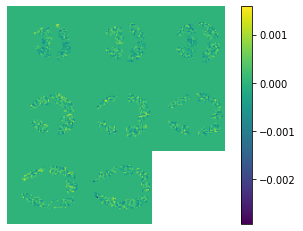

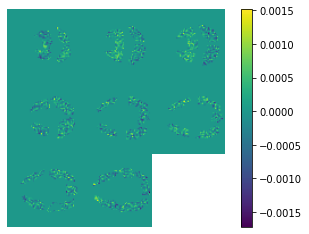

In [10]:
# visualize data
# use the existing tools or write your own!
plt.figure(1)
montage_array(p_training_data[0, :, :, :, 0], cmap='viridis')
plt.show()
plt.figure(2)
montage_array(p_test_data[0, :, :, :, 0], cmap='viridis')
plt.show()

In [11]:
num_classes = len(np.unique(labels)) #should be 2

#creating a matrix of training data from the training picture tensor
p_training_trials, p_training_dimx, p_training_dimy, p_training_dimz, p_training_times = p_training_data.shape
print(p_training_data.shape)
p_training_data_mat = p_training_data.reshape(p_training_trials,-1).T
print(p_training_data_mat.shape)

#creating a matrix of training data from the training sentence tensor
s_training_trials, s_training_dimx, s_training_dimy, s_training_dimz, s_training_times = s_training_data.shape
s_training_data_mat = s_training_data.reshape(s_training_trials,-1).T
print(s_training_data_mat.shape)

#creating a matrix of test data from the test picture tensor
p_test_trials, p_test_dimx, p_test_dimy, p_test_dimz, p_test_times = p_test_data.shape
p_test_data_mat = p_test_data.reshape(p_test_trials,-1).T
print(p_test_data_mat.shape)

#creating a matrix of test data from the test sentence tensor
s_test_trials, s_test_dimx, s_test_dimy, s_test_dimz, s_test_times = s_test_data.shape
s_test_data_mat = s_test_data.reshape(s_test_trials,-1).T
print(s_test_data_mat.shape)

#creating a single matrix of training data
training_data_mat = np.concatenate([p_training_data_mat,s_training_data_mat],axis=1)
print(training_data_mat.shape)

#creating a single matrix of test data
test_data_mat = np.concatenate([p_test_data_mat,s_test_data_mat],axis=1)
print(test_data_mat.shape)

#creating matrices for all of the labels
training_labels = np.concatenate([p_training_labels,s_training_labels])
test_labels = np.concatenate([p_test_labels,s_test_labels])
print(training_labels.shape)
print(test_labels.shape)

(26, 64, 64, 8, 16)
(524288, 26)
(524288, 26)
(524288, 14)
(524288, 14)
(524288, 52)
(524288, 28)
(52, 1)
(28, 1)


In [12]:
from sklearn.utils.extmath import randomized_svd
s_U, s_S, s_VT = randomized_svd(s_training_data_mat, n_components=26, n_iter=5, random_state=20)
p_U, p_S, p_VT = randomized_svd(p_training_data_mat, n_components=26, n_iter=5, random_state=20)

#I believe random_state is for reproducibility

In [13]:
# create the boolean array for training and testing
boolean_list = []
for i in (training_labels):
    boolean_list.append(i[0])
boolean_array_training = np.asarray(boolean_list)
print(boolean_array_training)
boolean_list = []
for i in (test_labels):
    boolean_list.append(i[0])
boolean_array_testing = np.asarray(boolean_list)
print(boolean_array_testing)

training_error = np.zeros([num_classes, training_data_mat.shape[1]])
test_error = np.zeros([num_classes, test_data_mat.shape[1]])
print(training_error.shape)
print(test_error.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
(2, 52)
(2, 28)


In [14]:
#I think the default norm for np.linalg.norm is the 2-norm
print(training_data_mat.shape[1])
for k in range(0,training_data_mat.shape[1]):
    p_difference = np.linalg.norm(np.asarray([training_data_mat[:,k]]).T - p_U @ (p_U.T @ np.asarray([training_data_mat[:,k]]).T))
    s_difference = np.linalg.norm(np.asarray([training_data_mat[:,k]]).T - s_U @ (s_U.T @ np.asarray([training_data_mat[:,k]]).T))
    training_error[0,k] = p_difference
    training_error[1,k] = s_difference

for k in range(0,test_data_mat.shape[1]):
    p_difference = np.linalg.norm(np.asarray([test_data_mat[:,k]]).T - p_U @ (p_U.T @ np.asarray([test_data_mat[:,k]]).T))
    s_difference = np.linalg.norm(np.asarray([test_data_mat[:,k]]).T - s_U @ (s_U.T @ np.asarray([test_data_mat[:,k]]).T))
    test_error[0,k] = p_difference
    test_error[1,k] = s_difference    

52


In [15]:
# classification
training_predicted_classes = np.argmin(training_error, axis=0).reshape(-1)
test_predicted_classes = np.argmin(test_error, axis=0).reshape(-1)

print(training_error.shape)
print(training_predicted_classes)

(2, 52)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


52
train accuracy = 100.00
test accuracy = 71.43


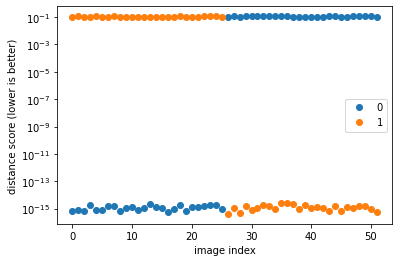

In [16]:
# results

print(training_data_mat.shape[1])

training_num_correct = np.sum(training_predicted_classes == boolean_array_training)
training_accuracy = training_num_correct / training_data_mat.shape[1]

test_num_correct = np.sum(test_predicted_classes == boolean_array_testing)
test_accuracy = test_num_correct / test_data_mat.shape[1]

print('train accuracy = %0.2f' % (100 * training_accuracy))
print('test accuracy = %0.2f' % (100 * test_accuracy))

# plot results
plt.figure()
for i in range(num_classes):
    plt.semilogy(training_error[i, :], 'o', label=i)

plt.xlabel('image index')
plt.ylabel('distance score (lower is better)')
plt.legend()
plt.show()

In [23]:
#finding the testing accuracy as we increase the number of components kept(less expressive basis -> more expressive basis)
test_accuracy_varied = []
print(s_training_data_mat.shape[1])
for rank in range(0,s_training_data_mat.shape[1]+1):
    s_U, s_S, s_VT = randomized_svd(s_training_data_mat, n_components=rank, n_iter=5, random_state=20)
    p_U, p_S, p_VT = randomized_svd(p_training_data_mat, n_components=rank, n_iter=5, random_state=20)
    training_error = np.zeros([num_classes, training_data_mat.shape[1]])
    test_error = np.zeros([num_classes, test_data_mat.shape[1]])
    
    #computing the error
    for k in range(0,training_data_mat.shape[1]):
        p_difference = np.linalg.norm(np.asarray([training_data_mat[:,k]]).T - p_U @ (p_U.T @ np.asarray([training_data_mat[:,k]]).T))
        s_difference = np.linalg.norm(np.asarray([training_data_mat[:,k]]).T - s_U @ (s_U.T @ np.asarray([training_data_mat[:,k]]).T))
        training_error[0,k] = p_difference
        training_error[1,k] = s_difference
    for k in range(0,test_data_mat.shape[1]):
        p_difference = np.linalg.norm(np.asarray([test_data_mat[:,k]]).T - p_U @ (p_U.T @ np.asarray([test_data_mat[:,k]]).T))
        s_difference = np.linalg.norm(np.asarray([test_data_mat[:,k]]).T - s_U @ (s_U.T @ np.asarray([test_data_mat[:,k]]).T))
        test_error[0,k] = p_difference
        test_error[1,k] = s_difference  
    # classification
    training_predicted_classes = np.argmin(training_error, axis=0).reshape(-1)
    test_predicted_classes = np.argmin(test_error, axis=0).reshape(-1)
    
    #training accuracy
    training_num_correct = np.sum(training_predicted_classes == boolean_array_training)
    training_accuracy = training_num_correct / training_data_mat.shape[1]
    
    #testing accuracy
    test_num_correct = np.sum(test_predicted_classes == boolean_array_testing)
    test_accuracy = test_num_correct / test_data_mat.shape[1]
    
    print('k = {}'.format(rank))
    print('test accuracy = %0.2f' % (100 * test_accuracy))
    
    test_accuracy_varied.append(test_accuracy)

26
k = 0
test accuracy = 50.00
k = 1
test accuracy = 71.43
k = 2
test accuracy = 71.43
k = 3
test accuracy = 67.86
k = 4
test accuracy = 78.57
k = 5
test accuracy = 78.57
k = 6
test accuracy = 71.43
k = 7
test accuracy = 75.00
k = 8
test accuracy = 71.43
k = 9
test accuracy = 75.00
k = 10
test accuracy = 71.43
k = 11
test accuracy = 75.00
k = 12
test accuracy = 75.00
k = 13
test accuracy = 75.00
k = 14
test accuracy = 75.00
k = 15
test accuracy = 71.43
k = 16
test accuracy = 71.43
k = 17
test accuracy = 71.43
k = 18
test accuracy = 71.43
k = 19
test accuracy = 75.00
k = 20
test accuracy = 75.00
k = 21
test accuracy = 75.00
k = 22
test accuracy = 75.00
k = 23
test accuracy = 71.43
k = 24
test accuracy = 71.43
k = 25
test accuracy = 71.43
k = 26
test accuracy = 71.43


<AxesSubplot:xlabel='Components', ylabel='Testing Accuracy'>

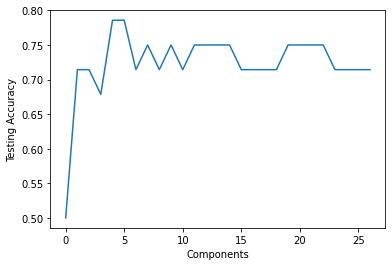

In [27]:
import seaborn as sns
import pandas as pd
d = {'Components': np.arange(27),'Testing Accuracy': test_accuracy_varied}
dataframe = pd.DataFrame(d)
sns.lineplot(data = dataframe,x='Components',y='Testing Accuracy')

In [32]:
print('Best number of components for highest accuracy is k = {} with accuracy = {}'.format(np.argmax(test_accuracy_varied),np.asarray(test_accuracy_varied).max()))

Best number of components for highest accuracy is k = 4 with accuracy = 0.7857142857142857
